In [3]:
!pip install -U scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/5c/e9/ee572691a3fb05555bcde41826faad29ae4bc1fb07982e7f53d54a176879/scikit_learn-1.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached scikit_learn-1.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
Using cached scikit_learn-1.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.utils import resample

%matplotlib inline

import logging

import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset

In [5]:
df = pd.read_csv("WISDM_ar_v1.1_raw.txt", sep = ' ', header = None)

df['lenght'] = df[0].apply(lambda x: x.split(',')).apply(lambda x: len(x))
filtred_df = df[~df['lenght'].isin([7, 11])]
filtred_df[0] = filtred_df[0].apply(lambda x: x.split(','))

columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
for i, el in enumerate(columns):
  if i != len(columns)-1:
    filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i])
  else:
    filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i][:-1])

filtred_df = filtred_df.drop(columns = [0, 'lenght', 'timestamp'])

/tmp/ipykernel_18283/379243730.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_df[0] = filtred_df[0].apply(lambda x: x.split(','))
/tmp/ipykernel_18283/379243730.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i])
/tmp/ipykernel_18283/379243730.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [6]:
le = preprocessing.LabelEncoder()
filtred_df['activity'] = le.fit_transform(filtred_df['activity'])

def transform(x):
  try:
    x = float(x)
  except ValueError:
    x = np.nan
  return x

for el in filtred_df.columns:
  filtred_df[el] = filtred_df[el].apply(lambda x: transform(x))

In [7]:
def group_by_user(df, user):
  return df[df['user'] == user].reset_index(drop = True)

def create_window(df, overlay, window_size, train_x, train_y):
  for i in range(0, df.shape[0], overlay):
    df_sub = df.iloc[i:i+window_size]

    if df_sub.shape[0] == window_size:
      train_x.append(df_sub[['x-axis', 'y-axis', 'z-axis']].to_numpy())
      train_y.append(df_sub['activity'].mode().iloc[0])

  return train_x, train_y


train_x = []
train_y = []

window_size = 100
overlay = 50

users = filtred_df['user'].unique().tolist()[:12]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, train_x, train_y)

print (len(train_x), len(train_y))

7968 7968


In [8]:
filtred_df['activity'].nunique()

6

In [9]:
test_x = []
test_y = []

users = filtred_df['user'].unique().tolist()[12:18]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, test_x, test_y)

print (len(test_x), len(test_y))

3381 3381


In [23]:
control_x = []
control_y = []

users = filtred_df['user'].unique().tolist()[18:32]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, control_x, control_y)

print (len(control_x), len(control_y))

8067 8067


In [10]:
train_dataset = TensorDataset(torch.tensor(np.array(train_x).transpose(0, 2, 1), dtype=torch.float32), torch.tensor(np.array(train_y).reshape(-1, 1), dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, drop_last = True)

test_dataset = TensorDataset(torch.tensor(np.array(test_x).transpose(0, 2, 1), dtype=torch.float32), torch.tensor(np.array(test_y).reshape(-1, 1), dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last = True)

In [26]:
control_dataset = TensorDataset(torch.tensor(np.array(control_x).transpose(0, 2, 1), dtype=torch.float32), torch.tensor(np.array(control_y).reshape(-1, 1), dtype=torch.float32))
control_loader = DataLoader(control_dataset, batch_size=256, shuffle=False, drop_last = True)

In [11]:
for inputs, labels in train_loader:
  print (inputs.shape, labels.shape)
  break

torch.Size([256, 3, 100]) torch.Size([256, 1])


In [12]:
for inputs, labels in test_loader:
  print (inputs.shape, labels.shape)
  break

torch.Size([256, 3, 100]) torch.Size([256, 1])


In [13]:
class ConvLSTMModel(nn.Module):
    def __init__(self):
        super(ConvLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=50, hidden_size=64, batch_first=True)
        self.dense1 = nn.Linear(64, 128)
        self.relu3 = nn.ReLU()
        self.dense2 = nn.Linear(128, 6)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.maxpool(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dense1(x)
        x = self.relu3(x)
        x = self.dense2(x)
        return x

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvLSTMModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [15]:
def calculate_accuracy(y_true, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_true, y_pred_labels)
    return accuracy

In [17]:
import gc
train_losses = []
valid_losses = []
def Train():

    running_loss = .0
    y_true = []
    y_pred_probs = []
    model.train()

    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        loss.backward()
        optimizer.step()
        running_loss += loss

        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'train_loss {train_loss}, train_accuracy {accuracy}')

def Valid():
    running_loss = .0
    y_true = []
    y_pred_probs = []
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds, labels.squeeze().long())
            running_loss += loss

            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(preds.detach().cpu().numpy())

        valid_loss = running_loss/len(test_loader)
        valid_losses.append(valid_loss.detach().numpy())

        y_true = np.array(y_true)
        y_pred_probs = np.array(y_pred_probs)
        accuracy = calculate_accuracy(y_true, y_pred_probs)

        print(f'validation_loss {valid_loss}, validation_accuracy {accuracy}')
    return valid_losses, accuracy

epochs = 200
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()

epochs 1/200
train_loss 1.781419038772583, train_accuracy 0.30317540322580644
validation_loss nan, validation_accuracy 0.41796875
epochs 2/200
train_loss 1.7767343521118164, train_accuracy 0.34185987903225806
validation_loss nan, validation_accuracy 0.44681490384615385
epochs 3/200
train_loss 1.7719652652740479, train_accuracy 0.3592489919354839
validation_loss nan, validation_accuracy 0.4534254807692308
epochs 4/200
train_loss 1.7670366764068604, train_accuracy 0.3602570564516129
validation_loss nan, validation_accuracy 0.4609375
epochs 5/200
train_loss 1.7618988752365112, train_accuracy 0.3511844758064516
validation_loss nan, validation_accuracy 0.4636418269230769
epochs 6/200
train_loss 1.7564834356307983, train_accuracy 0.3471522177419355
validation_loss nan, validation_accuracy 0.4636418269230769
epochs 7/200
train_loss 1.7507379055023193, train_accuracy 0.3471522177419355
validation_loss nan, validation_accuracy 0.4636418269230769
epochs 8/200
train_loss 1.7446074485778809, train

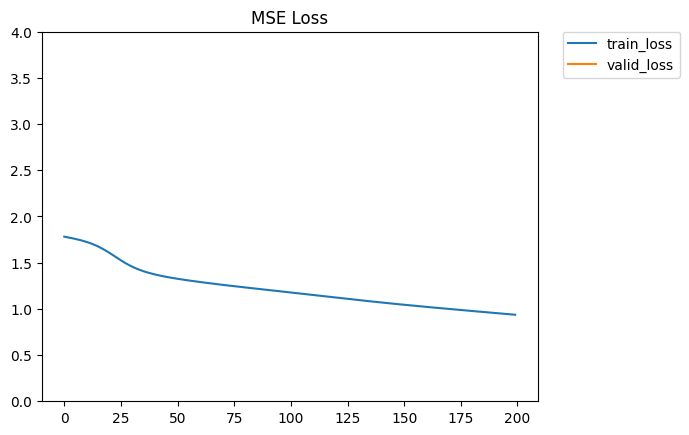

In [21]:
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
plt.ylim(0, 4)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [28]:
y_true = []
y_pred_probs = []
model.eval()

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(control_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())

        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())


    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'validation_accuracy {accuracy}')

validation_accuracy 0.6202116935483871
